In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio

from torch.utils.data import DataLoader, Dataset, ConcatDataset

import numpy as np
import matplotlib.pyplot as plt
import pyaudio 

import os

In [5]:
class NoiseDataset(Dataset):
    def __init__(self, audio_file, sample_rate = 44100, frame_size = 1024, threshold = 0.05):
        waveform, orig_sample_rate = torchaudio.load(audio_file)
        self.waveform = torchaudio.transforms.Resample(orig_freq=orig_sample_rate, new_freq=sample_rate)(waveform)
        self.sample_rate = sample_rate
        self.frame_size = frame_size
        self.threshold = threshold
        self.noise_indices = self._detect_noise(self.waveform)
        
    def _detect_noise(self, waveform):
        noise_indices = []
        energy = waveform.pow(2).mean(dim=0)
        for i in range(0, waveform.size(1) - self.frame_size, self.frame_size):
            frame_energy = energy[i:i+self.frame_size].mean().item()
            if frame_energy > self.threshold:
                noise_indices.append(i)
        return noise_indices

    def __len__(self):
        return len(self.noise_indices)
    
    def __getitem__(self, idx):
        start_idx = self.noise_indices[idx]
        end_idx = start_idx + self.frame_size
        noisy_segment = self.waveform[:, start_idx:end_idx]
        return noisy_segment, noisy_segment

In [6]:
class AntiNoiseLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(AntiNoiseLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

In [7]:
import numpy as np
import sounddevice as sd
import torch
import matplotlib.pyplot as plt
import pickle
import soundfile as sf

print(sd.query_devices())
 # 예를 들어, 1번 장치를 사용할 때

> 0 MacBook Pro 마이크, Core Audio (1 in, 0 out)
< 1 MacBook Pro 스피커, Core Audio (0 in, 2 out)


Recording...
Recording finished.
녹음된 오디오가 recorded_waveform_test_vol_3.wav에 저장되었습니다.
Recorded audio length: 5.0 seconds
Original Noise RMS: 0.8180
Anti-Noise RMS: 0.5646
Combined Noise RMS: 0.0927
Noise Reduction: 88.66%
결합된 파일이 combined_waveform_test_vol_3.wav에 저장되었습니다.


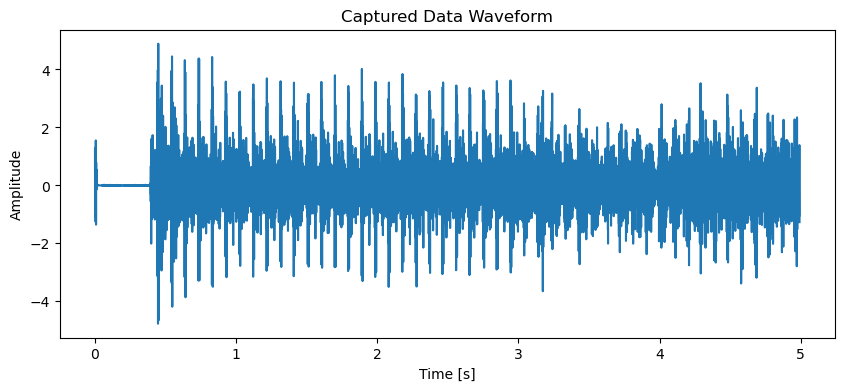

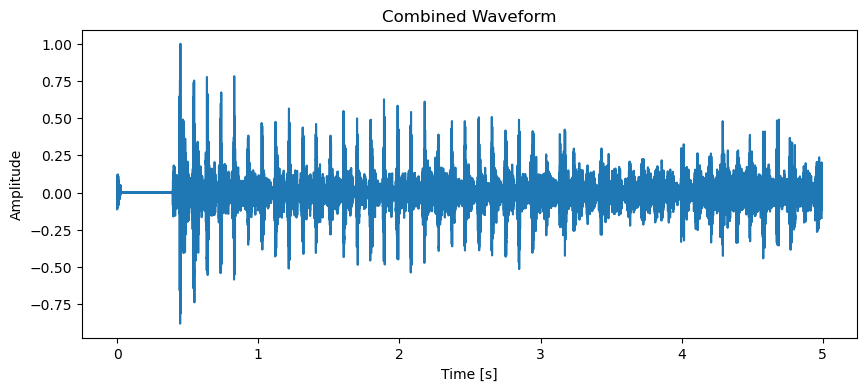

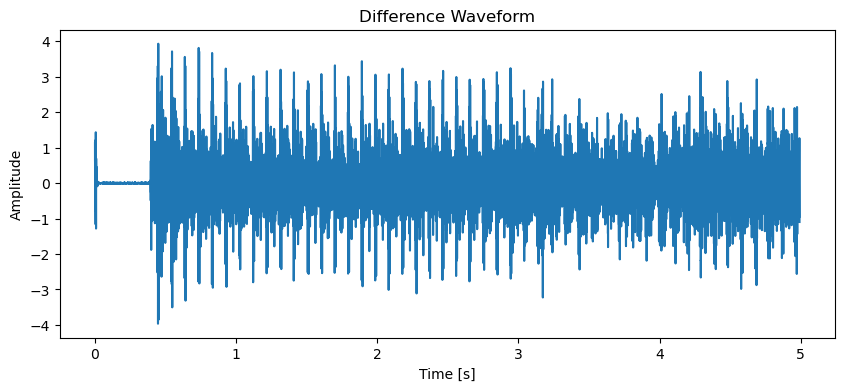

In [20]:
import numpy as np
import sounddevice as sd
import torch
import matplotlib.pyplot as plt
import pickle
import soundfile as sf

# RMS 계산 함수
def calculate_rms(signal):
    return np.sqrt(np.mean(signal**2))

# .pkl 파일에서 모델 로드
with open('/Users/junggwonhee/Desktop/programing/오아시스_해커톤/project/models/Noise_Lower_LSTM_vol_2.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

# 오디오 데이터 캡처 함수
def capture_and_predict(duration=5, samplerate=44100):
    # 오디오 데이터를 캡처
    print("Recording...")
    audio_data = sd.rec(int(duration * samplerate), samplerate=samplerate, channels=1, dtype='float32')
    sd.wait()  # 녹음 완료까지 대기
    print("Recording finished.")
    
    # 녹음된 오디오 데이터를 .wav 파일로 저장
    original_wav_path = 'recorded_waveform_test_vol_3.wav'
    sf.write(original_wav_path, audio_data, samplerate)
    print(f"녹음된 오디오가 {original_wav_path}에 저장되었습니다.")
    
    return audio_data

def process_and_concatenate(model, input_waveform, frame_size=1024):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    input_waveform = torch.tensor(input_waveform).unsqueeze(0).to(device).float()
    
    output_waveform = []
    
    for i in range(0, input_waveform.size(1), frame_size):
        input_frame = input_waveform[:, i:i+frame_size]
        if input_frame.size(1) == frame_size:
            with torch.no_grad():
                output_frame = model(input_frame).cpu().numpy().flatten()
                output_waveform.append(output_frame)
    
    # 결과를 이어붙이기
    output_waveform = np.concatenate(output_waveform)
    
    return output_waveform

# 시각화 함수
def plot_waveform(data, sample_rate, title):
    time_axis = np.linspace(0, len(data) / sample_rate, num=len(data))
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, data)
    plt.title(title)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.show()

# 오디오 데이터 캡처 및 모델 출력
live_audio_data = capture_and_predict(duration=5)
sample_rate = 44100  # 샘플레이트 지정

# 녹음된 데이터의 길이 확인
recorded_duration = len(live_audio_data) / sample_rate
print(f"Recorded audio length: {recorded_duration} seconds")

# live_audio_data는 2D numpy array로 반환되기 때문에 1D로 변환 필요
live_audio_data = live_audio_data.squeeze()

# 모델 예측 및 결합된 데이터 생성
output_waveform = process_and_concatenate(model, live_audio_data, frame_size=1024)

# 두 데이터의 길이 일치화
min_length = min(len(live_audio_data), len(output_waveform))
original_data = live_audio_data[:min_length]
output_waveform = output_waveform[:min_length]

# output_wav_path = "test1.wav"
# sf.write(output_wav_path, output_waveform, sample_rate)

# 두 파형 결합
combined_data = original_data + output_waveform

# 결합된 데이터의 정규화 (클리핑 방지)
combined_data = combined_data / np.max(np.abs(combined_data))

# RMS 값 계산
rms_original = calculate_rms(original_data)
rms_anti_noise = calculate_rms(output_waveform)
rms_combined = calculate_rms(combined_data)

# 소음 감소율 계산
noise_reduction_percentage = ((rms_original - rms_combined) / rms_original) * 100

# 결과 출력
print(f"Original Noise RMS: {rms_original:.4f}")
print(f"Anti-Noise RMS: {rms_anti_noise:.4f}")
print(f"Combined Noise RMS: {rms_combined:.4f}")
print(f"Noise Reduction: {noise_reduction_percentage:.2f}%")

# 결합된 데이터를 .wav 파일로 저장
output_wav_path = 'combined_waveform_test_vol_3.wav'
sf.write(output_wav_path, combined_data, sample_rate)

print(f"결합된 파일이 {output_wav_path}에 저장되었습니다.")

# 전체 구간에서의 파형 시각화
plot_waveform(original_data, sample_rate, "Captured Data Waveform")
plot_waveform(combined_data, sample_rate, "Combined Waveform")

# 결합 후의 차이 (원본 데이터에 대한 영향도 측정)
difference = original_data - combined_data
plot_waveform(difference, sample_rate, "Difference Waveform")
